In [9]:
from IPython.display import display_html

display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">显示/隐藏代码</button>""", raw=True)

显示/隐藏代码

1. 来源
https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python

2. 参考资料：pandas内存性能优化
http://blog.csdn.net/weiyongle1996/article/details/78498603?locationNum=3&fps=1

# Introduction

In this notebook, I go over some visualizations of the iceberg data. My purpose here is not to set up a classifier, but rather to try to get some sense of what types of features might be most useful.

* 在这个notebook里搞一点可视化。
* 不搞分类器，试试看什么类型的特征最有用。

As usual, we first have to import some packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train = pd.read_json('../data/processed/train.json')
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


I'll now read in the file. It is in a .json format rather than the .csv format that seems to be most common on Kaggle. It also turns out that "inc_angle" has some bad values, so I will convert it to a floating point format with the NaN values left in.

* 现在读取文件，这次是json不是csv。
* 在inc_angle中有一些错误值，全转成float型。

In [4]:
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


# Global Image Stats

Now, I will look at some global properties of the images. These are things like the minimum and maximum values, the means, medians, and the 50% mid range of the signal values. There are two different bands used in the file, so I'll do this separately for each band.

* 现在，查看图像的全局属性。
* 包括，最大最小值、均值、中位数，最后一个（50% mid range）是啥？
* 文件里包含两个不同的band，全局属性将分别计算。

In [5]:
def get_stats(train,label=1):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)] ]
    train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train['band_'+str(label)] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)] ]
    train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train['band_'+str(label)] ]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train['band_'+str(label)] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)] ]
    train['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in train['band_'+str(label)] ]
    train['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in train['band_'+str(label)] ]
    train['mid50_'+str(label)] = train['p75_'+str(label)]-train['p25_'+str(label)]
    return train

train = get_stats(train,1)
train = get_stats(train,2)

# Plotting the Statistics

Now, we can make some histograms of these variables. I'll make histograms of both classes to see if there are any differences.

* 现在我们对这些变量做些统计。
* 对两个类别分别做统计，来看看这些属性有没有差异。

In [7]:
def plot_var(name,nbins=50):
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

C:\Anaconda2\envs\python3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Anaconda2\envs\python3\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


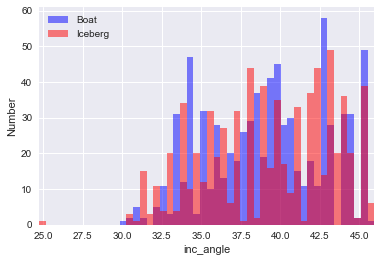

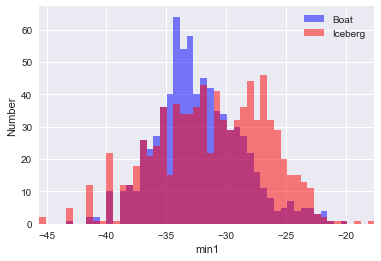

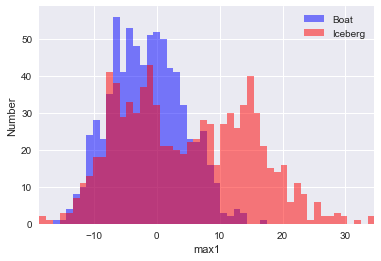

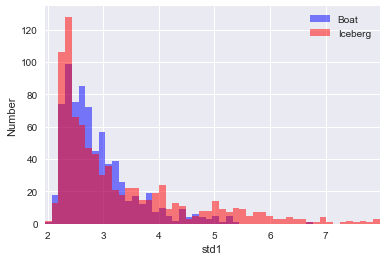

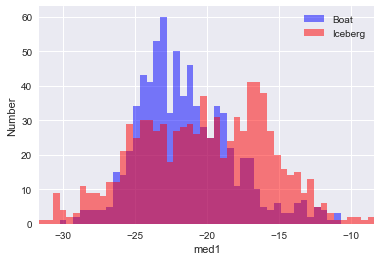

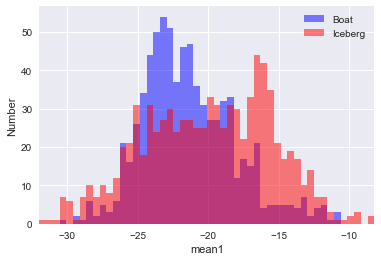

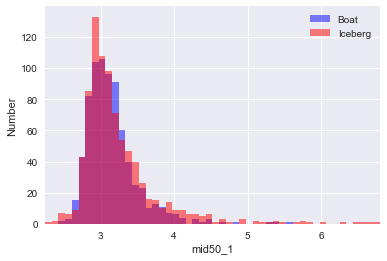

In [10]:
for col in ['inc_angle','min1','max1','std1','med1','mean1','mid50_1']:
    plot_var(col)

For the first band, we see that there are some significant differences. The middle 50% range has around the same size for both, but the minimum, maximum, standard deviation, median, and mean all show noticeable differences in some range of the values. Evidently, these basic variables seem to have some sensitivity to what we are trying to measure. We might expect this if, for example, icebergs are much larger than ships and thus cover more pixels.

* 在对比第一个band时，可以看到一些显著的区别。
    * **mid 50% range**基本没差；
    * minimum, maximum, standard deviation, median, and mean都有显著的区别。
* 显然，这些基础特征似乎和我们尝试测度的目标有关。
* 我们可以猜测，比如，冰山覆盖的像素比船只大得多。

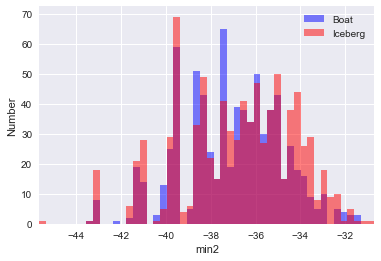

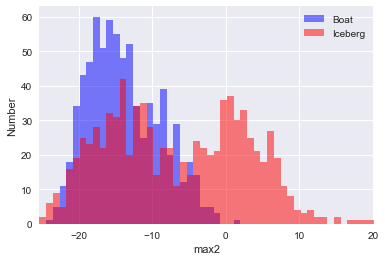

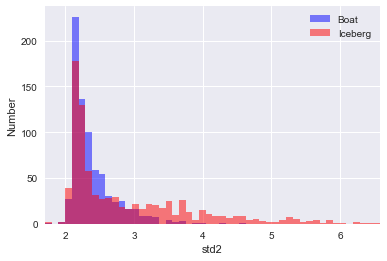

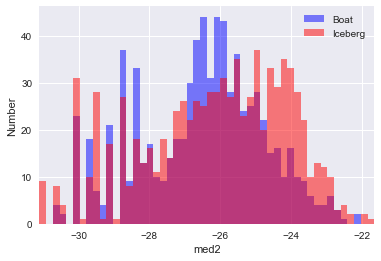

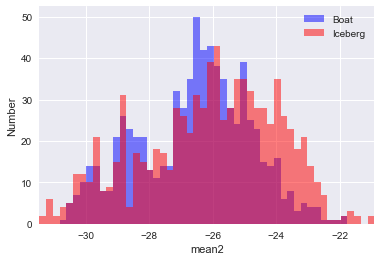

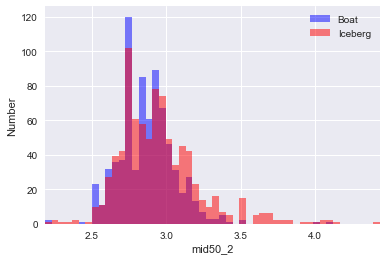

In [11]:
for col in ['min2','max2','std2','med2','mean2','mid50_2']:
    plot_var(col)

We get similar results for the second band.

* 第二个band有类似的结论。

# Correlations Between Features

Now that we've established that these variables may have some use, we should look at the correlations between them. For this, I'll just plot the correlation matrix. It would also be good to look at scatter plots of each pair of variables (this can be done easily in Seaborn), but i won't do that here.

* 现在我们知道这些个变量会有用，现在看看这些变量间的相关性。
* 只是画个相关性矩阵。
* 绘制每对变量间的散点图会更好，但是这里不画。

In [13]:
train_stats = train.drop(['id','is_iceberg','band_1','band_2'], axis=1)

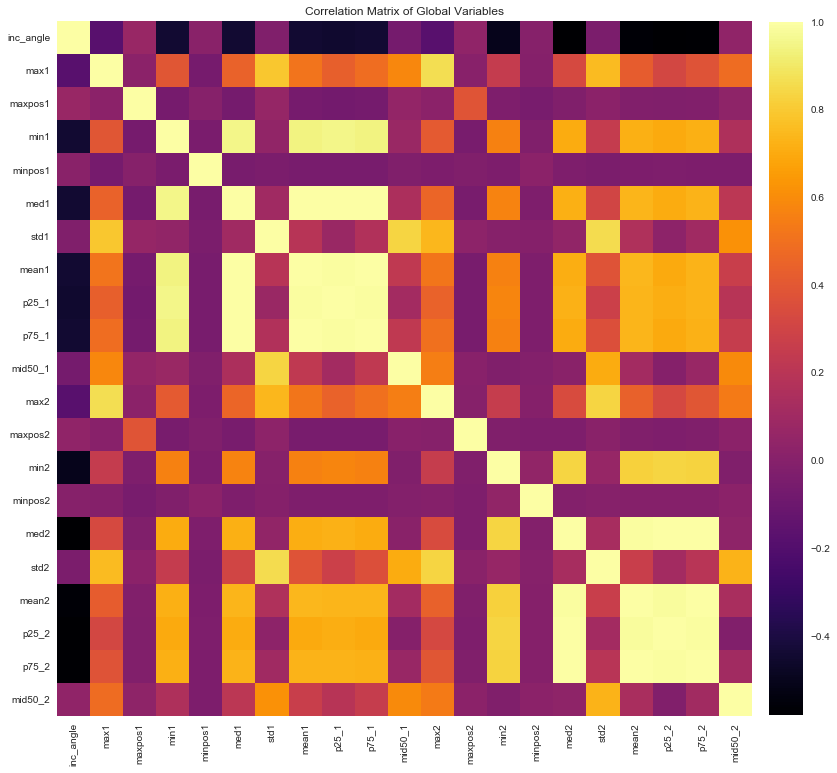

In [21]:
corr = train_stats.corr()
fig = plt.figure(1, figsize=(15,15))
plt.imshow(corr,cmap='inferno')
labels = np.arange(len(train_stats.columns))
plt.xticks(labels,train_stats.columns,rotation=90)
plt.yticks(labels,train_stats.columns)
plt.title('Correlation Matrix of Global Variables')
cbar = plt.colorbar(shrink=0.85,pad=0.02)
plt.grid(False)
plt.show()

We see that there are large correlations between some of the variables. In particular, the mean, median, 25% signal, and 75% signal are all closely related, with nearly 75% correlation. The min and max are also pretty highly correlated for band 1, as are the min and median for both bands, suggesting that the signals have maybe been scaled in some way to force this correlation. There are also some correlations between the two bands. Finally, we see an anticorrelation of around -0.5 between the mean of band 2 and the angle, with a weaker correlation for band 1.

* 可以看到部分变量间相关度很大。
* 特别是mean, median, 25% signal, 75% signal之间紧密的相关。
* 在band1中，min和max也高度相关，同样，min和median在两个band中也都高度相关；这意味着信号可能通过经过某种缩放。
* 两个band间也有相关性。
* 最后，我们可以看到band2的mean和angle之间有大约-0.5的负相关，和band1中的相关度较弱。

# Plotting Some Images

It's good to plot some images before we do too much analysis. That way, we can get some sense of what we're looking at. The images are 75 x 75 pixels each with two bands.

* 在进一步分析前，画个图比较好。
* 这样，我们可以对在看啥数据有点感觉。
* 两个band都是75 * 75。

In [16]:
icebergs = train[train.is_iceberg==1].sample(n=9,random_state=123)
ships = train[train.is_iceberg==0].sample(n=9,random_state=456)

# Raw Images

The first set show 9 random icebergs using band 1.

* 随机显示9张冰山的band1。

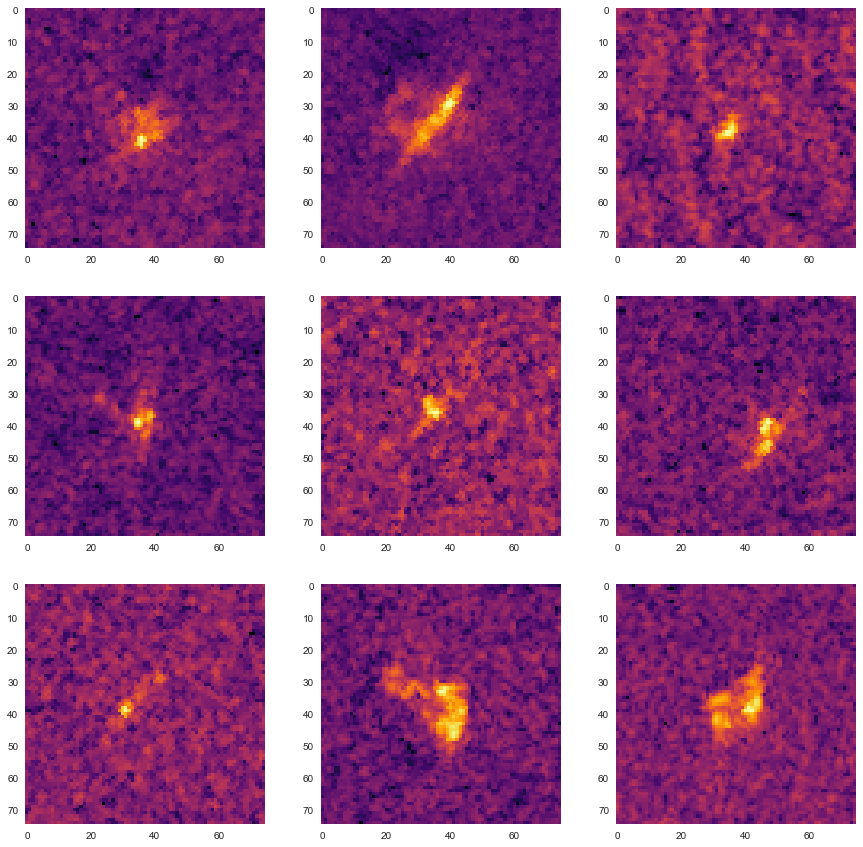

In [18]:
# Plot icebergs band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,0]),(75,75))
    ax.imshow(arr,cmap='inferno')
    ax.grid(False)
    
plt.show()

The second set shows ships in band 1.

* 第二组图片显示船只的band1。

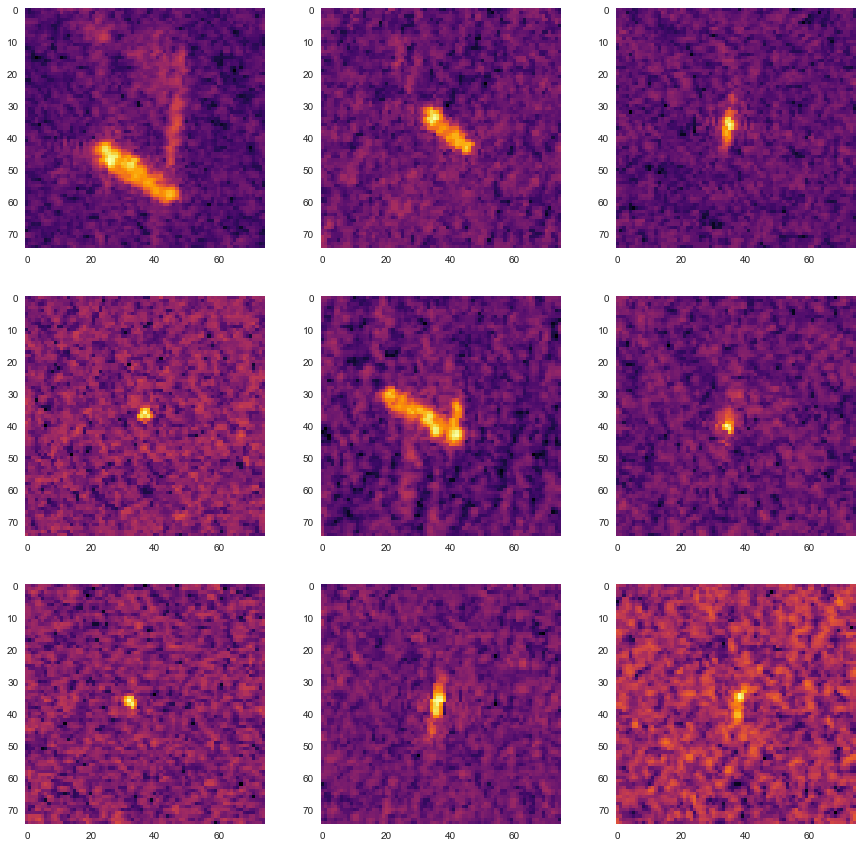

In [25]:
# Plot ships band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,0]),(75,75))
    ax.imshow(arr,cmap='inferno')
    ax.grid(False)
    
plt.show()

The next set show the same set of icebergs in band 2.

* 下面画冰山的band2。

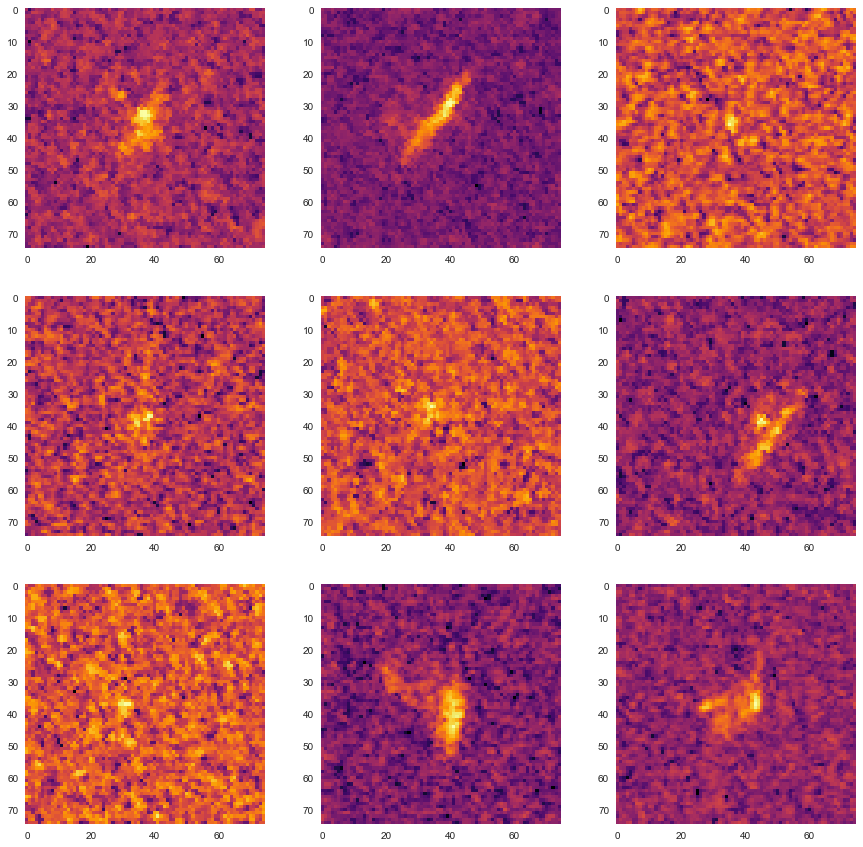

In [23]:
# Plot icebergs band_2
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    ax.grid(False)

plt.show()

Finally, the last set are the same ship images as before, but for band 2.

* 最后画船只的band2。

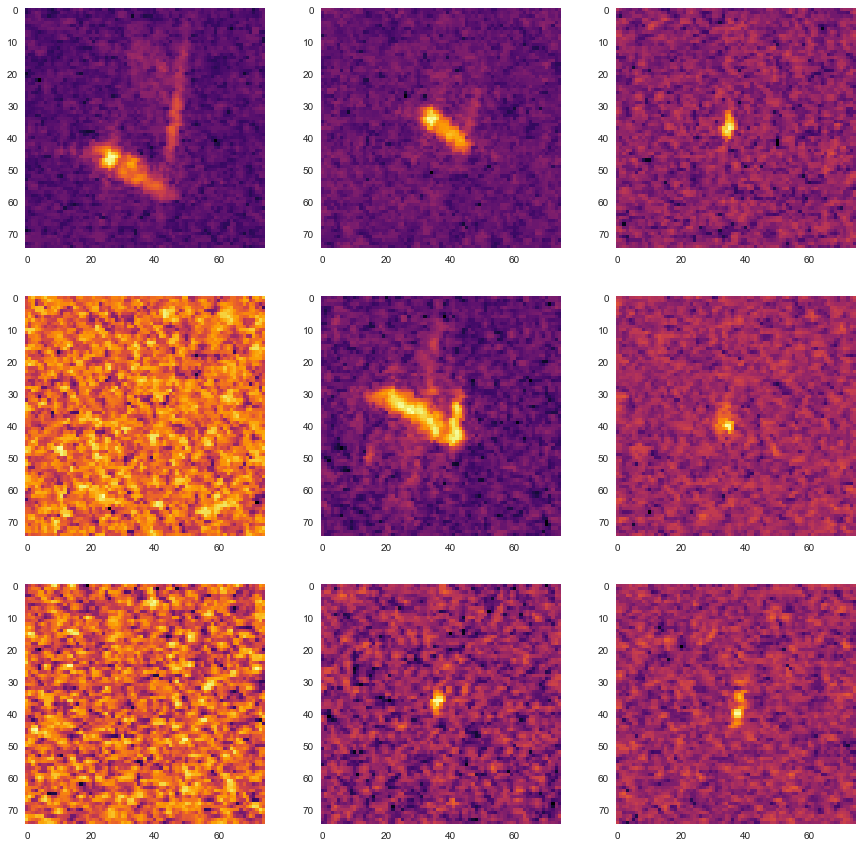

In [26]:
# Plot ships band_2
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    ax.grid(False)

plt.show()

So, we see that everything looks pretty blob-like. It also appears that the background is not really random noise but rather has some spatial correlations. If the background is dominated by things like waves rather than noise, then spatial correlations would clearly be expected. The ships seem to have a more regular structure, with a pronounced skewness in the blobs for larger signals.

* 所有的东西看起来都斑斑点点的。
* 背景看起来并不是随机噪音，而是有某些空间关系。
* 船只看起来有更加规律的结构，且伴有一个更显著的偏差值的斑点对应更强的信号。

Some of these blobs are not that high above noise, and in the last set there are even two images where the signal cannot even be seen by eye, so it may be advantageous to first transform the images in some way to enhance the contrast between the signals and the background.

* 某些这样的斑点并不比噪音更强。
* 在最后一组图片中，甚至有两张图片中的信号肉眼无法识别。
* 所以，首先用某种方法增强信号和背景之间的差异可能会有好处。

# Transforming the Images

I'll look at a few types of basic transforms that can be easily defined by FIR filters. The scipy convolve2d function will run a convolution of two arrays, so we just need to define the kernels. I have not optimized the kernels here, and there are many other choices of types of kernels, so you should try out different options to see what they do.

* 我们通过FIR滤波来做一些基础的转换。
* scipy的convolve2d函数是用来做卷积的，我们只需要定义卷积核。
* 这里不去优化卷积核，实际上选择很多，但是这里不试。

In [27]:
from scipy import signal

xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
smooth = np.array([[1,1,1],[1,5,1],[1,1,1]])
xder2 = np.array([[-1,2,-1],[-3,6,-3],[-1,2,-1]])
yder2 = np.array([[-1,-3,-1],[2,6,2],[-1,-3,-1]])

# Smoothing

First, let's try smoothing the images. The kernel here just has all positive values and is symmetric in both directions.
I'll first plot the icebergs and then the ships. These are all for Band 1.

* 首先，我们试着平滑图像。
* 卷积核实各向同性的全正数。
* 接下来，先画冰山再画船，都用Band1。

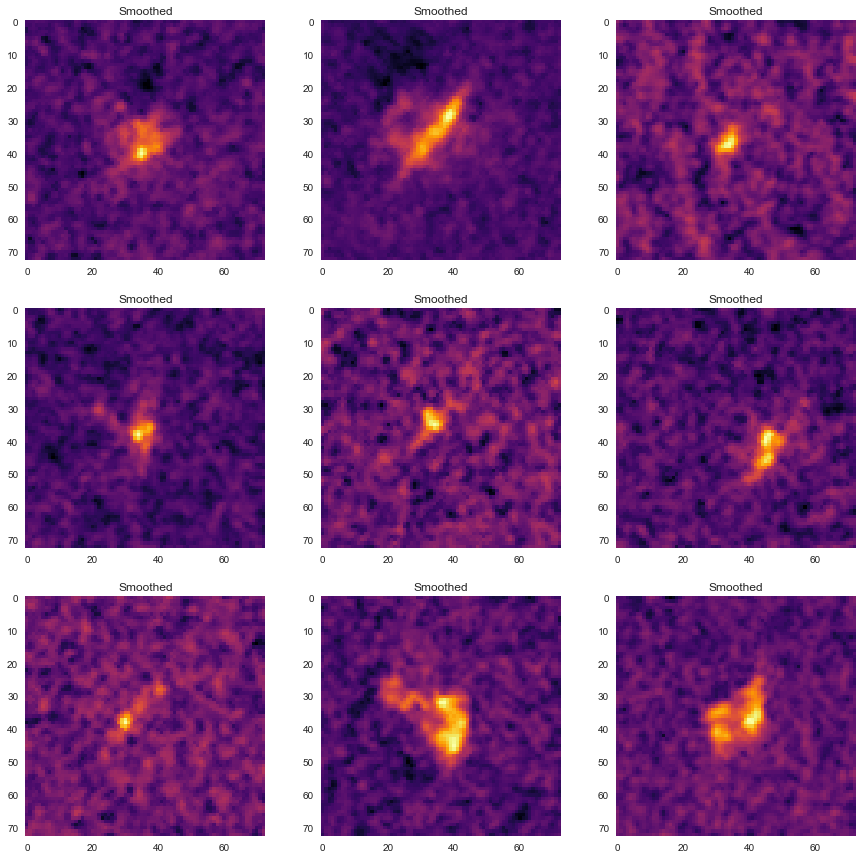

In [28]:
# Plot icebergs band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]), (75,75)), smooth,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('Smoothed')
    ax.grid(False)
    
plt.show()

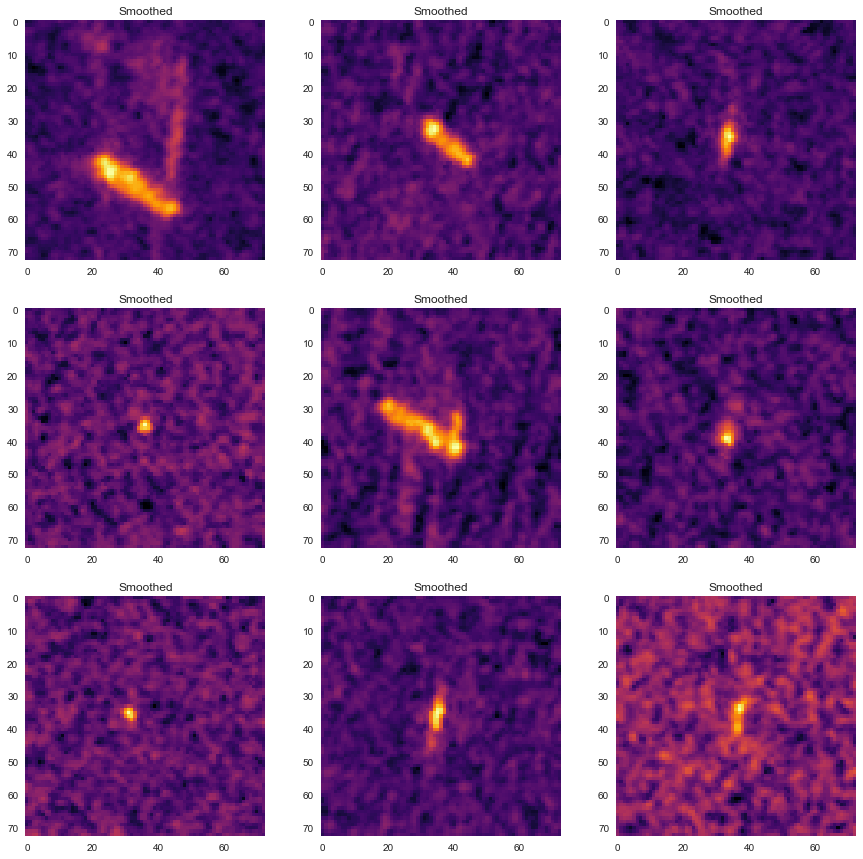

In [30]:
# Plot ships band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),smooth,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('Smoothed')
    ax.grid(False)
    
plt.show()

As we might expect, smoothing blurs the features. However, it also enhances the contrast between bright and dark regions, so it may be quite useful if we want to use it to seed some clusters in a cluster/peak finder.

* 如我们所料，平滑会模糊特征。
* 然而，平滑同样增强了明部和暗部的对比；这对找到聚类/峰值有帮助。

# Derivative with Respect to X

An X-derivative will typically be antisymmetric with respect to reversing the values around the x-axis. This will provide some level of edge detection in the x-direction. I will take the derivatives of the original images.

* X-微分非对称，绝对值关于x轴对称的两个值相反。
* 这个操作提供了一些边缘检测的效果。

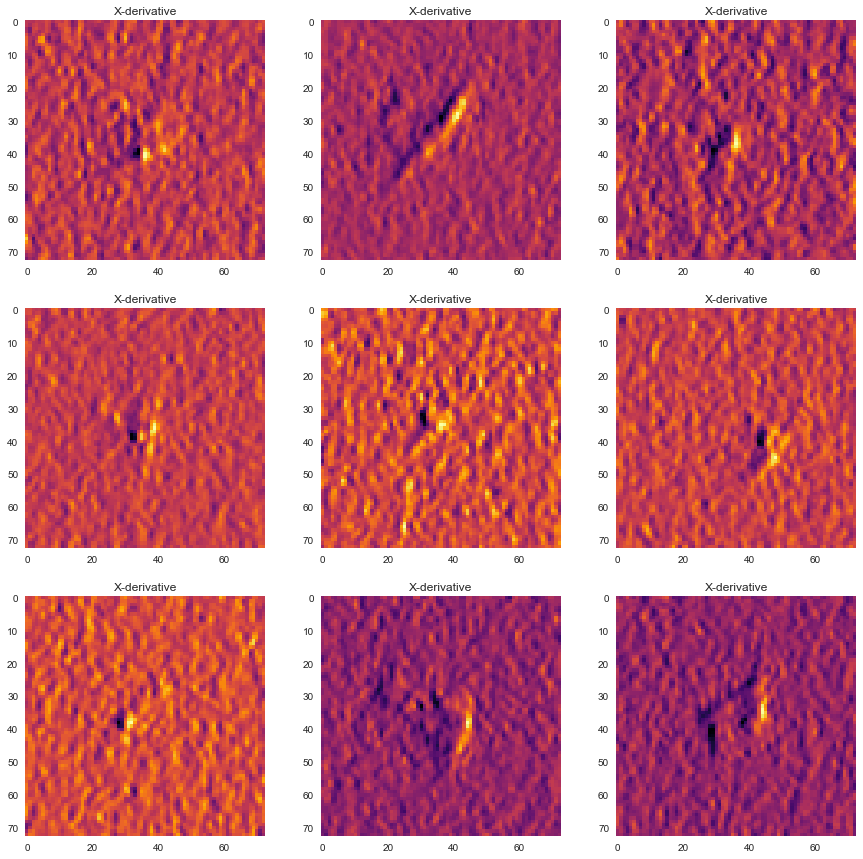

In [31]:
# Plot icebergs band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),xder,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('X-derivative')
    ax.grid(False)
    
plt.show()

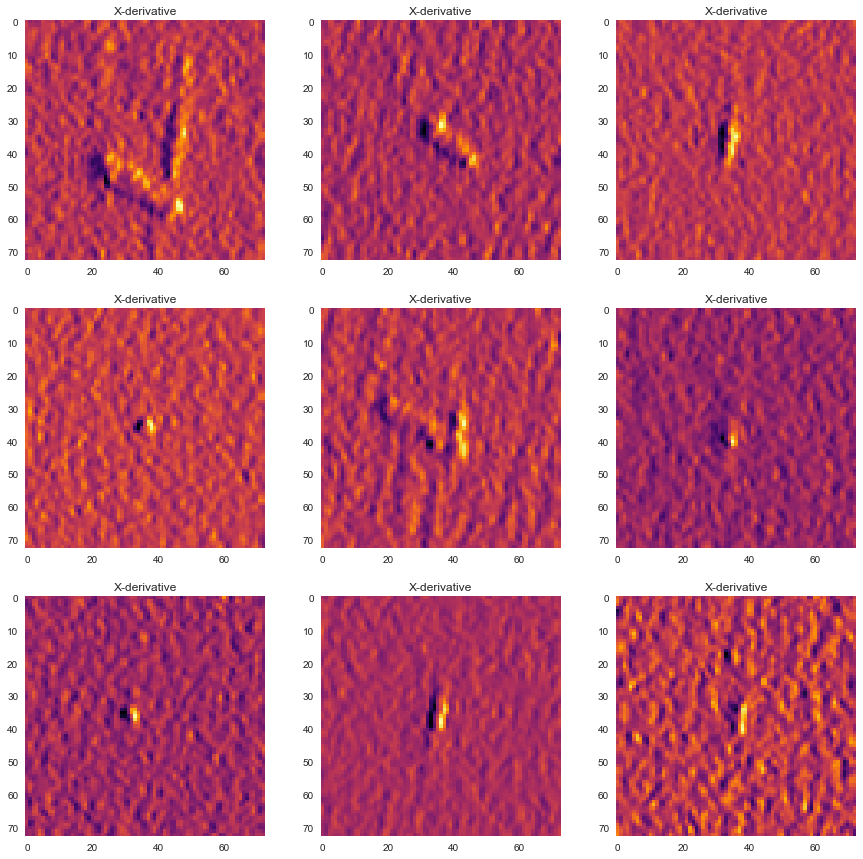

In [33]:
# Plot ships band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('X-derivative')
    ax.grid(False)
    
plt.show()

Note that you should see a dark region on the left side of a peak and a bright region on the right. If you look closely enough, you should see that the positions may have changed in all of these transformations. This is because I have chosen not to zero-pad the arrays. The resulting transformed arrays are slightly smaller than the input.

* 注意，在信号峰值的左侧应该有块暗部，而右侧有块亮部。
* 如果看得足够仔细，你会发现图片的位置在这些变换后都产生了变化。
* 这是因为没有对向量做**zero-pad**。
* 变换结果向量比输入向量小一些。

# Gradient Magnitude

It should also be trivial to see how to do a y-derivative. Rather than that, we can look at the magnitude of the gradient. That is, treat the x and y derivatives as a gradient vector at each position and then take the magnitude at each point.

* Y-微分的做法是显而易见的。
* 不做那个，我们可以看梯度的2范数。（magnitude是啥？）
* 把前面做的X-微分和Y-微分作为梯度向量，然后计算每个点的范数。

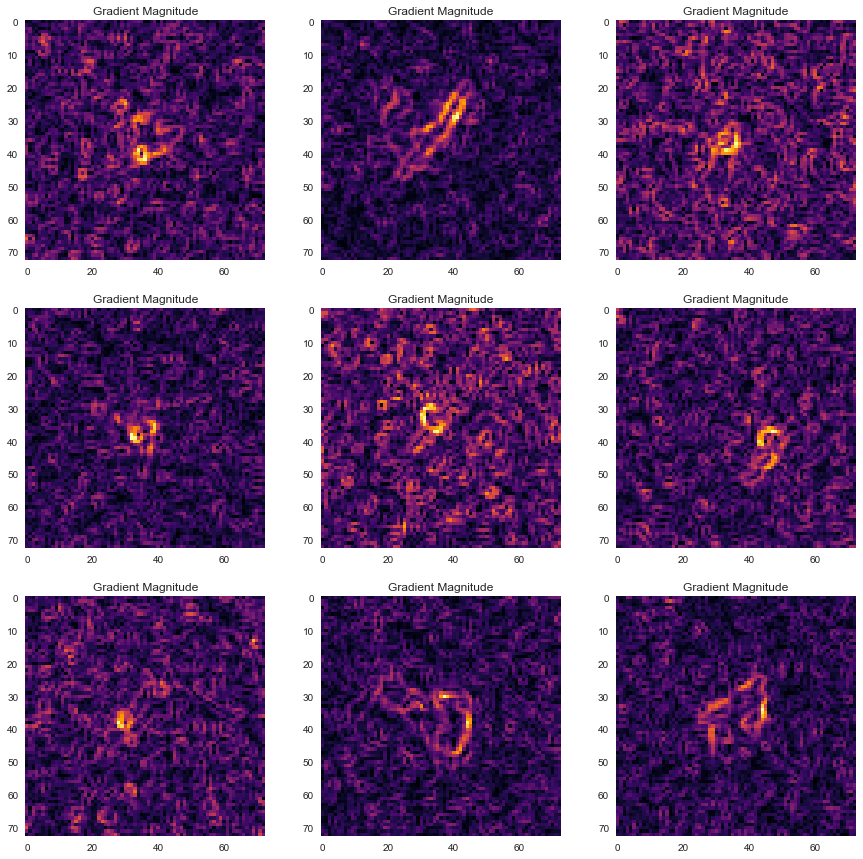

In [34]:
# Plot icebergse band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude')
    ax.grid(False)

plt.show()

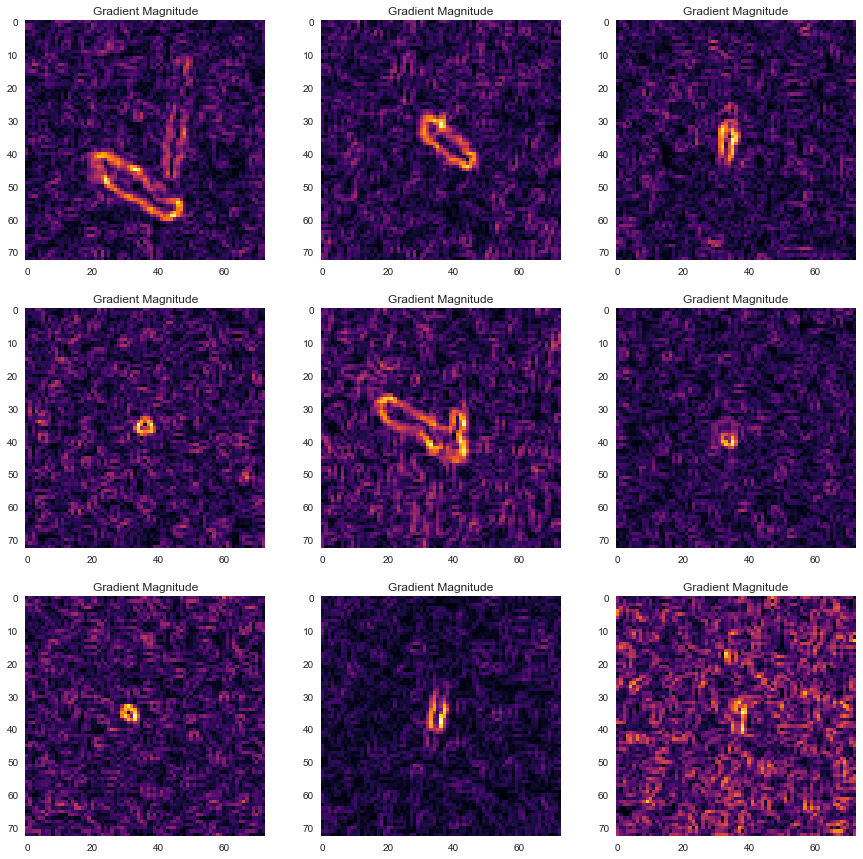

In [35]:
# Plot ships band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude')
    ax.grid(False)
    
plt.show()

We see interesting circular shapes everywhere in these images. But, the signals look fairly strong. The ships, in particular, show fairly bright edges and most create nice loops. This sort of operator might be useful to put into a more advanced model like a neural net. At the very least, it would be good to compare the results using this against things like the raw and smoothed data.

* 我们看到这些图片中到处存在有趣的圈圈。
* 特别的，这些船只有明亮的边缘，通常表现出完好的环形。
* 

# Second Derivatives
We can also define a simple second-derivative operator. A 3x3 second derivative should do less smoothing than a 3x3 first derivative, so we might see less contrast between the signal and the background.